# 04 – Embedding integrado con Harmony sobre genes altamente variables

Notebook dedicado a la **integración por Harmony** sobre el objeto normalizado.  
Calcula PCA sobre HVG, corrige batch con Harmony y guarda el embedding integrado
en `adata.obsm[EMB_KEY]` para los notebooks siguientes.

## 1. Contexto: batch effects e integración con Harmony

- El dataset combina células de distintas **bibliotecas / pacientes** → aparecen efectos de batch.
- Sin corrección, las células tienden a agruparse por origen técnico más que por tipo celular.
- Harmony (Korsunsky et al., 2019):
  - Toma un embedding inicial (PCA).
  - Ajusta ese embedding para reducir la dependencia de un **batch_key** (p.ej. `gem_id`).
  - Intenta conservar la estructura biológica dentro de cada lote.
- En este notebook:
  - PCA sobre **genes altamente variables** (HVG).
  - Harmony sobre las PCs usando un batch_key detectado en `adata.obs`.
  - Embedding final guardado en `adata.obsm[EMB_KEY]`, típicamente `"X_pca_harmony"`.

In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import harmonypy as hm

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)
print("Harmony (harmonypy) importado correctamente.")

Scanpy: 1.11.5
AnnData: 0.12.6
Harmony (harmonypy) importado correctamente.


C:\Users\Coni\AppData\Local\Temp\ipykernel_8264\559830621.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_8264\559830621.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


## 2. Organización de carpetas y configuración básica

- Se asume este notebook en `notebooks/` y se definen:
  - `PROJECT_ROOT`, `AI_PACKAGE_DIR`, `DATA_RAW_DIR`, `DATA_PROCESSED_DIR`.
- Se lee `AI_Package/MANIFEST.json` (si existe) para recuperar:
  - `EMB_KEY` (embedding Harmony, p.ej. `"X_pca_harmony"`),
  - `NBR_KEY` (neighbors, p.ej. `"harmony"`),
  - `UMAP_KEY` (UMAP integrado, p.ej. `"X_umap_harmony"`).
- Entrada principal configurada en:
  - `NORMALIZED_H5AD_PATH = data_processed/TFM_CIRRHOSIS_normalized.h5ad`.
- Salida con Harmony:
  - `TFM_CIRRHOSIS_harmony.h5ad` en `data_processed/`.

In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
DATA_RAW_DIR        = PROJECT_ROOT / "data_raw"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
DATA_PROCESSED_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta data_raw:", DATA_RAW_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)

# Leemos MANIFEST.json para recuperar las claves estándar
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

EMB_KEY = manifest.get("keys", {}).get("EMB_KEY", "X_pca_harmony")
NBR_KEY = manifest.get("keys", {}).get("NBR_KEY", "harmony")
UMAP_KEY = manifest.get("keys", {}).get("UMAP_KEY", "X_umap_harmony")

CONFIG = {
    "PROJECT_ROOT": PROJECT_ROOT,
    "AI_PACKAGE_DIR": AI_PACKAGE_DIR,
    "DATA_RAW_DIR": DATA_RAW_DIR,
    "DATA_PROCESSED_DIR": DATA_PROCESSED_DIR,
    # Usamos el objeto normalizado completo (no subset HVG)
    "NORMALIZED_H5AD_PATH": DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_normalized.h5ad",
    "EMB_KEY": EMB_KEY,      # normalmente "X_pca_harmony"
    "NBR_KEY": NBR_KEY,      # normalmente "harmony"
    "UMAP_KEY": UMAP_KEY,    # normalmente "X_umap_harmony"
}

CONFIG

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta data_raw: D:\Users\Coni\Documents\TFM_CirrhosIS\data_raw
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed


{'PROJECT_ROOT': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS'),
 'AI_PACKAGE_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package'),
 'DATA_RAW_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_raw'),
 'DATA_PROCESSED_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed'),
 'NORMALIZED_H5AD_PATH': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/TFM_CIRRHOSIS_normalized.h5ad'),
 'EMB_KEY': 'X_pca_harmony',
 'NBR_KEY': 'harmony',
 'UMAP_KEY': 'X_umap_harmony'}

## 3. Carga del objeto normalizado y restringido a HVG

- Se carga **el objeto normalizado completo**:

  - `data_processed/TFM_CIRRHOSIS_normalized.h5ad`.

- Estructura esperada:
  - `adata.layers["log1p_10k"]`: expresión normalizada + log1p.
  - `adata.layers["counts"]`: cuentas crudas.
  - `adata.var["highly_variable"]`: HVG marcados (~3k genes).
- Aunque el título hable de “restringido a HVG”, en la implementación actual:
  - se carga el objeto completo,
  - y solo se **subconjunta a HVG en memoria** para PCA,
  - el archivo guardado sigue conteniendo **todos los genes**.

In [3]:
# 3. Carga del objeto normalizado completo (con HVG anotados en adata.var)

normalized_h5ad_path = CONFIG["NORMALIZED_H5AD_PATH"]

if not normalized_h5ad_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo normalizado en:\n{normalized_h5ad_path}\n"
        "Asegúrate de que has ejecutado el notebook de normalización (03) "
        "o ajusta CONFIG['NORMALIZED_H5AD_PATH'] a la ruta correcta."
    )

adata = sc.read_h5ad(normalized_h5ad_path)
print(adata)

AnnData object with n_obs × n_vars = 225944 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'
    layers: 'counts', 'log1p_10k'


In [4]:
print("Número de genes:", adata.n_vars)
print("Número de células:", adata.n_obs)

# Comprobamos que siguen marcados los HVG
if "highly_variable" in adata.var.columns:
    print("Nº de HVGs marcados:", int(adata.var["highly_variable"].sum()))
else:
    print("[AVISO] No se encuentra 'highly_variable' en adata.var.")

print("\nColumnas disponibles en adata.obs (posibles batch keys):")
print(list(adata.obs.columns))

# Información rápida de gem_id y patientID, si existen
if "gem_id" in adata.obs.columns:
    print("\nNúmero de gem_id únicos:", adata.obs["gem_id"].nunique())
    print(adata.obs["gem_id"].value_counts().head())
if "patientID" in adata.obs.columns:
    print("\nNúmero de patientID únicos:", adata.obs["patientID"].nunique())
    print(adata.obs["patientID"].value_counts().head())

Número de genes: 38606
Número de células: 225944
Nº de HVGs marcados: 2976

Columnas disponibles en adata.obs (posibles batch keys):
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']

Número de gem_id únicos: 8
gem_id
ee31rg5x_hsm6kstq    38633
w1oxhhll_d4comu1j    37787
eoogcieu_var4q976    37766
hner8v5o_m8skafb5    35404
glol8w2k_5hkzluhi    23573
Name: count, dtype: int64

Número de patientID únicos: 16
patientID
CNAG_118    37787
CNAG_117 

## 4. Selección del batch key para Harmony

- Se inspeccionan columnas de `adata.obs` para elegir un `batch_key`:

  - prioridad: `gem_id` → `libraryID` → `sample` → `sample_id` → `batch` → `patientID`.

- Criterio:
  - usar columnas con **>1 nivel** (más de un lote),
  - en la práctica, se espera `batch_key = "gem_id"` (biblioteca técnica).
- Si no se detecta `batch_key`:
  - Harmony no se aplica,
  - el embedding final será el PCA sin corregir, copiado a `adata.obsm[EMB_KEY]`
    para mantener una interfaz uniforme.

In [5]:
# 4. Selección del batch key para Harmony

available_obs = list(adata.obs.columns)
print("Columnas disponibles en adata.obs:")
print(available_obs)

batch_key = None

# Preferimos gem_id como batch técnico si existe y hay >1
if "gem_id" in adata.obs.columns and adata.obs["gem_id"].nunique() > 1:
    batch_key = "gem_id"
# Si no hubiera gem_id, probamos otras columnas típicas
elif "libraryID" in adata.obs.columns and adata.obs["libraryID"].nunique() > 1:
    batch_key = "libraryID"
elif "sample" in adata.obs.columns and adata.obs["sample"].nunique() > 1:
    batch_key = "sample"
elif "sample_id" in adata.obs.columns and adata.obs["sample_id"].nunique() > 1:
    batch_key = "sample_id"
elif "batch" in adata.obs.columns and adata.obs["batch"].nunique() > 1:
    batch_key = "batch"
# patientID lo consideramos última opción como batch (más biológico que técnico)
elif "patientID" in adata.obs.columns and adata.obs["patientID"].nunique() > 1:
    batch_key = "patientID"

print("\nBatch key detectado automáticamente:", batch_key)

if batch_key is not None:
    print("\nFrecuencia de células por lote (batch_key):")
    print(adata.obs[batch_key].value_counts())
else:
    print("\n[AVISO] No se ha detectado automáticamente un batch_key.")
    print("Harmony se aplicaría sin batch explícito (no recomendable en este dataset).")

Columnas disponibles en adata.obs:
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']

Batch key detectado automáticamente: gem_id

Frecuencia de células por lote (batch_key):
gem_id
ee31rg5x_hsm6kstq    38633
w1oxhhll_d4comu1j    37787
eoogcieu_var4q976    37766
hner8v5o_m8skafb5    35404
glol8w2k_5hkzluhi    23573
pizamr6y_jgzygjwf    21110
ul6ge419_oxt3y11v    19303
kbdmjydj_hyfxxft5    12368
Name: count, dtype: int64


## 5. PCA sobre genes altamente variables

- Se asegura que `adata.X` contenga la matriz log-normalizada:

  - si existe, se usa `adata.layers["log1p_10k"]`.

- Se construye un objeto temporal restringido a HVG:

  - `adata_hvg = adata[:, adata.var["highly_variable"]].copy()`.

- Sobre `adata_hvg` se ejecuta:
  - `sc.pp.scale(adata_hvg)` (centrado y escalado por gen),
  - `sc.tl.pca(adata_hvg, n_comps=N_PCS)` con `N_PCS = 30`.
- Resultados:
  - `adata_hvg.obsm["X_pca"]` → PCs en HVG.
  - Se copian las PCs a `adata.obsm["X_pca"]` (todas las células, mismas PCs).
  - Se reconstruyen las cargas en `adata.varm["PCs"]` alineadas a **todos los genes**.
- Se visualiza la varianza explicada (`sc.pl.pca_variance_ratio` en `adata_hvg`)
  para confirmar que ~30 PCs capturan la mayor parte de la señal útil.

Usando la capa 'log1p_10k' como matriz base para PCA.
Número de genes altamente variables utilizados en PCA: 2976


C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Forma de adata_hvg.obsm['X_pca']: (225944, 30)


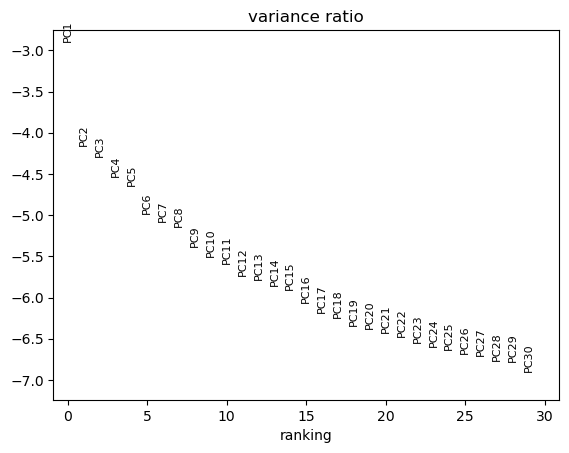

In [6]:
# 5. PCA sobre genes altamente variables

# Aseguramos que .X contiene la matriz log-normalizada (log1p_10k)
# generada en el notebook 03
if "log1p_10k" in adata.layers:
    adata.X = adata.layers["log1p_10k"].copy()
    print("Usando la capa 'log1p_10k' como matriz base para PCA.")
else:
    print("[AVISO] No se encontró la capa 'log1p_10k'; se usará adata.X tal cual.")

# Escalado y PCA solo sobre los genes altamente variables (~3k),
# manteniendo todas las células (~226k). Esto es lo estándar en scRNA-seq
# y evita densificar una matriz 226k x 38k que no cabe en memoria.
import numpy as np

# Máscara de genes altamente variables
if "highly_variable" not in adata.var.columns:
    raise ValueError(
        "No se encontró la columna 'highly_variable' en adata.var. "
        "Asegúrate de haber ejecutado antes el notebook 03."
    )

hvg_mask = adata.var["highly_variable"].to_numpy()
n_hvg = int(hvg_mask.sum())
print(f"Número de genes altamente variables utilizados en PCA: {n_hvg}")

# Objeto temporal restringido a HVG (no se guarda en disco)
adata_hvg = adata[:, hvg_mask].copy()

# Escalado de expresión (sin max_value=10, según recomendación de la tutora)
sc.pp.scale(adata_hvg)

# PCA usando únicamente los HVG escalados
N_PCS = 30  # número de componentes principales a calcular (para Harmony trabajaremos con 30 PCs)
sc.tl.pca(
    adata_hvg,
    n_comps=N_PCS,
    svd_solver="arpack",
)

print("Forma de adata_hvg.obsm['X_pca']:", adata_hvg.obsm["X_pca"].shape)

# Transferimos los PCs al objeto completo para usarlos en Harmony y pasos posteriores
adata.obsm["X_pca"] = adata_hvg.obsm["X_pca"].copy()

# También alineamos las cargas de los PCs (varm["PCs"]) a la dimensión completa de genes
pcs_full = np.zeros((adata.n_vars, N_PCS), dtype=adata_hvg.varm["PCs"].dtype)
pcs_full[hvg_mask, :] = adata_hvg.varm["PCs"]
adata.varm["PCs"] = pcs_full

# Visualizamos la varianza explicada usando el objeto HVG
sc.pl.pca_variance_ratio(adata_hvg, log=True)

## 6. Aplicación de Harmony

- Se toman las primeras `N_PCS` componentes:

  - `X_pca = adata.obsm["X_pca"][:, :N_PCS]`.

- Si hay `batch_key`:
  - `hm.run_harmony(X_pca, adata.obs, batch_key)` devuelve un embedding corregido.
  - `Z_corr` (PCs corregidas) se transpone y se guarda en:

    - `adata.obsm[EMB_KEY]` (p.ej. `"X_pca_harmony"`).

- Si **no** hay `batch_key`:
  - no se ejecuta Harmony,
  - se copia `X_pca` directamente a `adata.obsm[EMB_KEY]`.
- Inspección rápida:
  - se imprime la forma del embedding integrado,
  - se puede visualizar `EMB_KEY` coloreado por `gem_id` y/o `disease` si existen en `adata.obs`.

2025-12-27 22:53:37,942 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Ejecutando Harmony usando batch_key = 'gem_id' y las primeras 30 PCs ...


C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2025-12-27 22:54:05,612 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-27 22:54:06,539 - harmonypy - INFO - Iteration 1 of 10
2025-12-27 22:55:44,328 - harmonypy - INFO - Iteration 2 of 10
2025-12-27 22:57:23,279 - harmonypy - INFO - Iteration 3 of 10
2025-12-27 22:59:00,577 - harmonypy - INFO - Converged after 3 iterations


Forma del embedding corregido: (225944, 30)
Embedding Harmony guardado en adata.obsm['X_pca_harmony'].
Embedding almacenado en adata.obsm['X_pca_harmony'] con forma: (225944, 30)
Primeras 5 filas (primeras 5 PCs):
[[-1.1214139e+01 -2.1076379e+00 -3.4778932e-01 -2.8112736e+00
   3.5265441e+00]
 [ 1.3248647e+01  8.5753119e-01 -6.2107784e-01 -1.1220506e-02
  -1.5534908e+00]
 [ 1.6110838e+01  1.6625354e+00 -9.9156117e-01  1.1862887e-01
  -5.1066190e-01]
 [-1.0450578e+01 -3.6695473e+00  1.7798248e-01  9.4328203e+00
  -5.3300295e+00]
 [-8.9704561e+00 -3.7452714e+00  9.6209258e-01  1.0024948e+01
  -7.6372366e+00]]

Mostrando embedding de 'X_pca_harmony' coloreado por: gem_id, disease


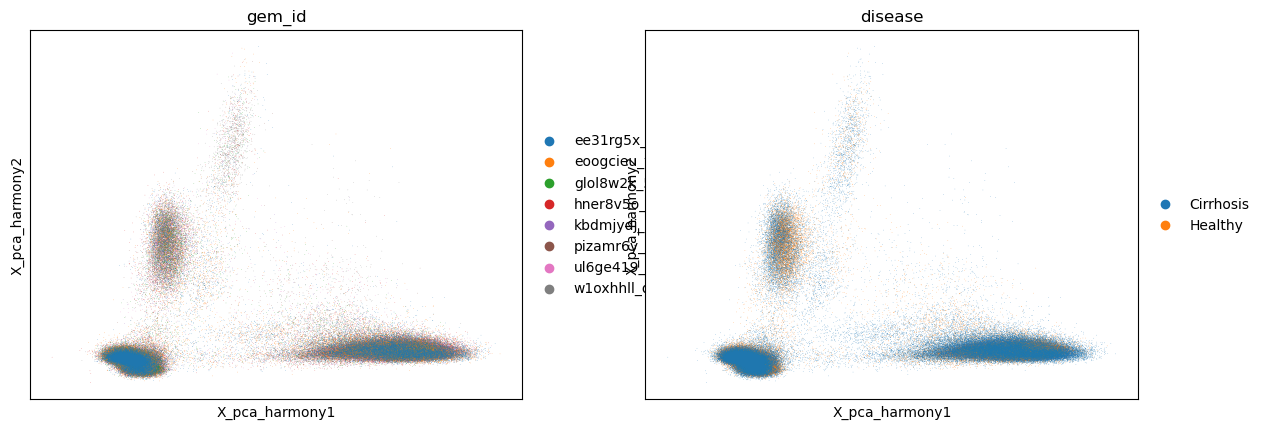

In [7]:
# 6. Aplicación de Harmony

# Usamos explícitamente las primeras N_PCS componentes principales
X_pca = adata.obsm["X_pca"][:, :N_PCS]

if batch_key is not None:
    print(f"Ejecutando Harmony usando batch_key = '{batch_key}' "
          f"y las primeras {N_PCS} PCs ...")
    ho = hm.run_harmony(X_pca, adata.obs, batch_key)
    # harmonypy devuelve PCs corregidas con forma (PCs x células)
    Z_corr = ho.Z_corr.T
    print("Forma del embedding corregido:", Z_corr.shape)
    adata.obsm[EMB_KEY] = Z_corr
    print(f"Embedding Harmony guardado en adata.obsm['{EMB_KEY}'].")
else:
    print("[AVISO] No se ha definido batch_key; no se aplicará Harmony.")
    print(f"Se copiará el PCA original (primeras {N_PCS} PCs) a adata.obsm['{EMB_KEY}'].")
    adata.obsm[EMB_KEY] = X_pca.copy()

# Inspección rápida del embedding integrado
if EMB_KEY in adata.obsm:
    emb = adata.obsm[EMB_KEY]
    print(f"Embedding almacenado en adata.obsm['{EMB_KEY}'] con forma:", emb.shape)
    print("Primeras 5 filas (primeras 5 PCs):")
    print(emb[:5, :5])

    # Visualización rápida: usamos sc.pl.embedding con el basis = EMB_KEY
    # Comprobamos qué columnas existen realmente en adata.obs
    candidate_colors = ["gem_id", "disease"]
    colors = [c for c in candidate_colors if c in adata.obs.columns]

    if colors:
        print(
            f"\nMostrando embedding de '{EMB_KEY}' coloreado por: "
            + ", ".join(colors)
        )
        sc.pl.embedding(
            adata,
            basis=EMB_KEY,
            color=colors,
            ncols=min(2, len(colors)),
        )
    else:
        print(
            "\n[AVISO] No se encontraron columnas 'gem_id' ni 'disease' en adata.obs; "
            "se omite la visualización coloreada."
        )
else:
    print(f"[AVISO] No se encontró la clave '{EMB_KEY}' en adata.obsm.")

## 7. Guardado del objeto con Harmony

- Se guarda el objeto AnnData completo, que ahora contiene:

  - datos normalizados + log1p (`adata.layers["log1p_10k"]`, `adata.X`),
  - cuentas crudas (`adata.layers["counts"]`),
  - HVG en `adata.var["highly_variable"]`,
  - PCA en `adata.obsm["X_pca"]`,
  - embedding integrado Harmony (o copia de PCA) en `adata.obsm[EMB_KEY]`.

- Ruta de salida:

  - `data_processed/TFM_CIRRHOSIS_harmony.h5ad`.

In [8]:
# 7. Guardado del objeto con Harmony

# Guardamos el objeto completo (no subsetado), que ahora incluye:
# - Datos normalizados/log-transformados
# - Anotación de HVG en adata.var["highly_variable"]
# - Embedding PCA en adata.obsm["X_pca"]
# - Embedding Harmony en adata.obsm[EMB_KEY]
harmony_h5ad_path = CONFIG["DATA_PROCESSED_DIR"] / "TFM_CIRRHOSIS_harmony.h5ad"

adata.write_h5ad(harmony_h5ad_path)

print(f"Objeto con embedding Harmony guardado en:\n{harmony_h5ad_path}")
print(f"Embedding integrado almacenado en adata.obsm['{EMB_KEY}'].")

Objeto con embedding Harmony guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_harmony.h5ad
Embedding integrado almacenado en adata.obsm['X_pca_harmony'].


## 8. Resumen de este notebook

- Entrada: `TFM_CIRRHOSIS_normalized.h5ad` con:
  - expresión log-normalizada,
  - cuentas crudas,
  - HVG anotados.
- Selección automática de un `batch_key` (típicamente `gem_id`) a partir de `adata.obs`.
- PCA sobre genes altamente variables:
  - escalado + 30 PCs,
  - PCs copiados a `adata.obsm["X_pca"]`.
- Integración con Harmony:
  - corrige efectos de lote entre bibliotecas,
  - guarda el embedding final en `adata.obsm[EMB_KEY]` (p.ej. `"X_pca_harmony"`).
- Salida: `TFM_CIRRHOSIS_harmony.h5ad`, que se usará en los siguientes notebooks para:
  - construir el grafo de vecinos (`neighbors_key = NBR_KEY`),
  - calcular UMAP integrado (`UMAP_KEY`),
  - y hacer clustering / definición de linajes Level1/Level2.

## Comentarios

- En la ejecución real del TFM:
  - el objeto normalizado tiene ~226k células y ~38k genes,
  - ~2976 genes marcados como HVG,
  - `batch_key` detectado: `gem_id` (8 bibliotecas).
- Harmony converge en pocas iteraciones y el embedding:
  - mezcla bien los distintos `gem_id`,
  - mantiene diferencias biológicas asociadas a `disease` (Cirrhosis vs Healthy).
- El archivo `TFM_CIRRHOSIS_harmony.h5ad` es el punto de partida estándar
  para vecinos, UMAP y clustering integrados en los notebooks posteriores.